# On Analyzing Real World Time Series for Forecasting Stock Data - Tencent

In [1]:
from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, RandomWalk, PersistenceWalkForward, AR, MA, ARMA, ARIMA_model, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Split Raw Data
7. Initialize and Predict Random Walk `RW` Model for Raw Data
8. Plot Actual Forecasts vs Predicted Forecasts for Raw Data
9. Initialize Autoregressive Moving Average `ARIMA(p, d, q)` for Raw Data
10. Predict Forecasts for Raw Data
11. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
12. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-05", "2023-10-23"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("TCEHY", "Tencent"),
    ("INTC", "Intel")
]
independent_variable = "Close"
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'TCEHY'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 4.47399998,  4.48000002,  4.29799986, ..., 38.20000076,
       37.18000031, 36.75      ])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2010-01-05,4.474000
2010-01-06,4.480000
2010-01-07,4.298000
2010-01-08,4.290000
2010-01-11,4.440000
...,...
2023-10-16,38.500000
2023-10-17,38.360001
2023-10-18,38.200001


### Plot Raw Data

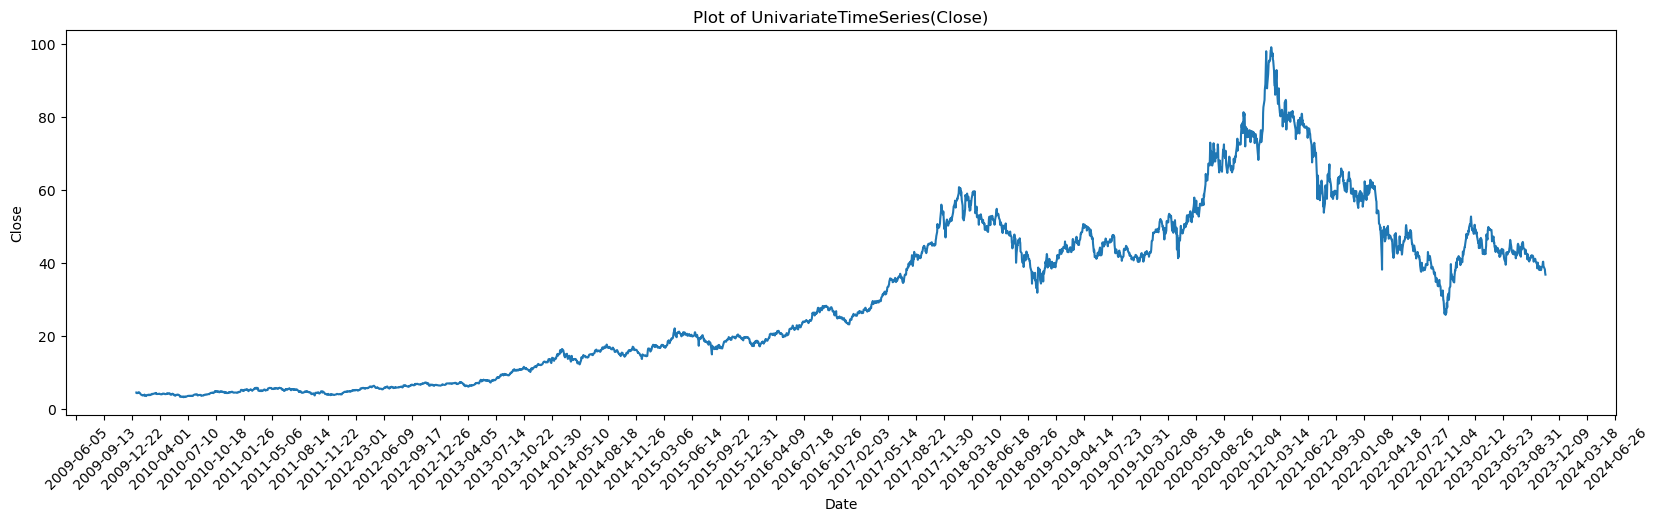

In [7]:
stocks[stock_symbol].plot(tick_skip=100)

- Tencent went public Jan 4, 2010 [yfinance](https://finance.yahoo.com/quote/TCEHY/history?period1=1262649600&period2=1698537600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).
- What happened in 2018 for the Tencent stock close observations to fall?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What happened in 2020 for the Tencent stock close observations to fall?
    - Covid-19, so what happened in China during Covid? How did customers and end users react to company during the pandemic?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What's the future of the China market? Tencent?
- How long will it take for Tencent to see another peak stock close observation?

<AxesSubplot: xlabel='Date'>

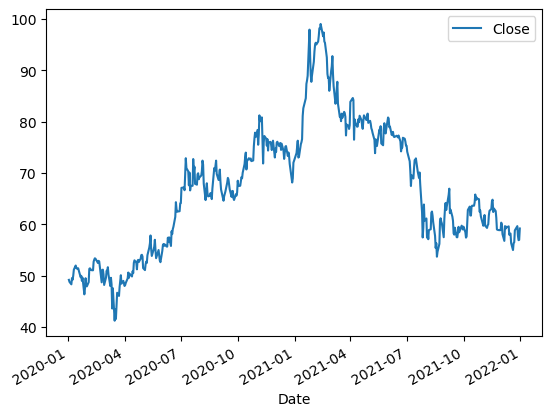

In [8]:
stock_df.loc['2020-01-01':'2022-01-01'].plot()

### Get Descriptive Statistics of Raw Data

In [9]:
stocks[stock_symbol].get_statistics()

,Close
count,3473.000000
mean,30.570110
std,22.368257
min,3.182000
25%,7.806000
50%,26.299999
75%,46.570000
max,99.010002


In [10]:
stocks[stock_symbol].max_min_range()

{'Max': Close    99.010002
 dtype: float64,
 'Min': Close    3.182
 dtype: float64,
 'Range': Close    95.828002
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [11]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: -1.287693
p-value: 0.634784 > 0.05 , so non-stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

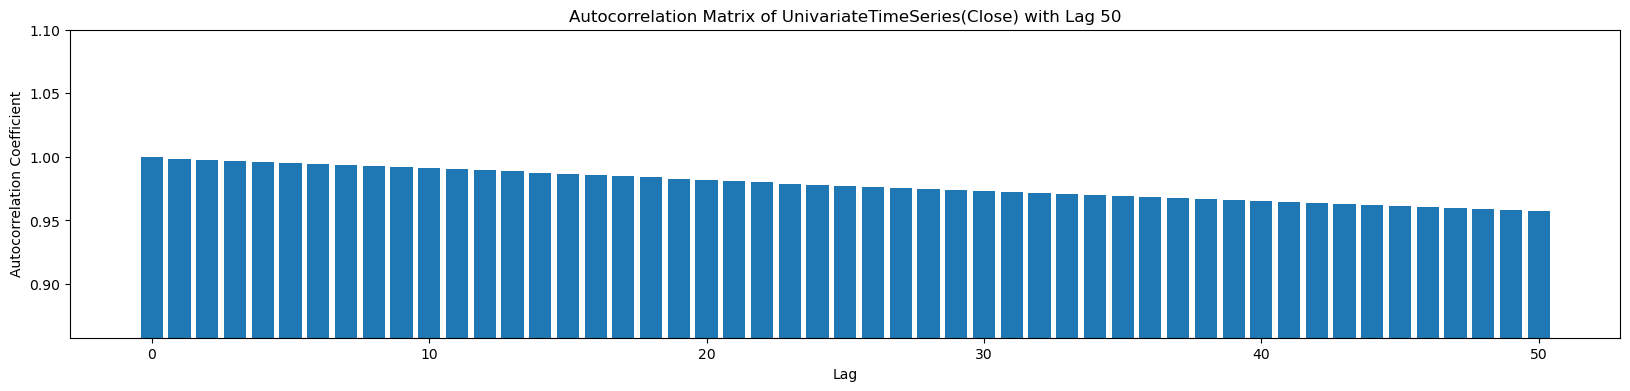

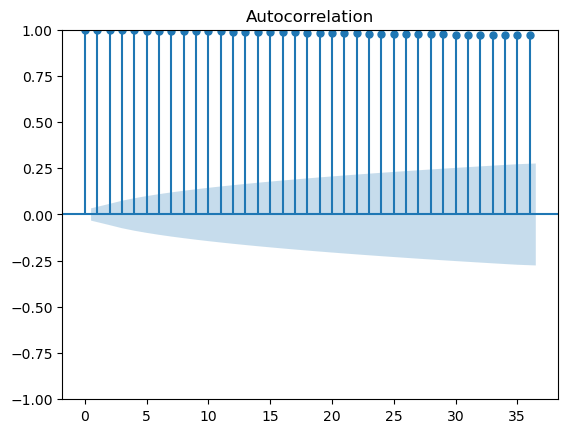

In [12]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

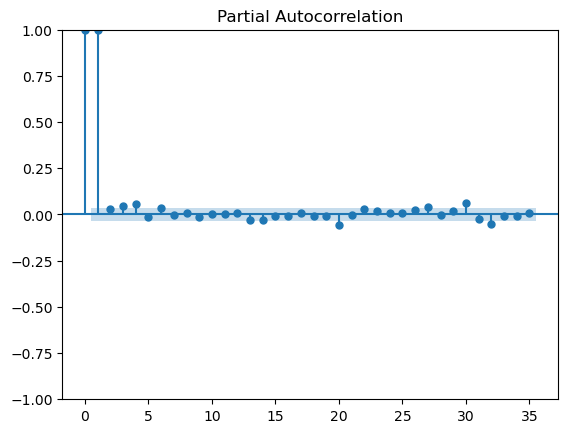

In [13]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Split Raw Data

In [14]:
stock_close = stocks[stock_symbol]
stock_close

UnivariateTimeSeries(Close)

In [15]:
stock_close_df = stock_close.get_as_df()
stock_close_df

,Close
Date,
2010-01-05,4.474000
2010-01-06,4.480000
2010-01-07,4.298000
2010-01-08,4.290000
2010-01-11,4.440000
...,...
2023-10-16,38.500000
2023-10-17,38.360001
2023-10-18,38.200001


In [16]:
stock_close_len = len(stock_close_df)
stock_close_len

3473

In [17]:
get_close_train_len = len(stock_close_df[:3466])
get_close_train_len

3466

In [18]:
get_close_train_percentage = float(get_close_train_len / stock_close_len)
get_close_train_percentage

0.9979844514828679

In [19]:
train_raw, validation_raw, test_raw = stock_close.get_train_validation_test_split(get_close_train_percentage, 0.0)

0 3466
3466 3466
3466 3473


In [20]:
train_data_series = train_raw.get_series()
train_data_series

array([ 4.47399998,  4.48000002,  4.29799986, ..., 39.        ,
       39.5       , 40.25      ])

In [21]:
expected_forecasts_df = test_raw.get_as_df()
expected_forecasts_df

,UnivariateTimeSeries(Close)[3466:3473]
Date,
2023-10-12,40.290001
2023-10-13,39.099998
2023-10-16,38.500000
2023-10-17,38.360001
2023-10-18,38.200001
2023-10-19,37.180000
2023-10-20,36.750000


In [22]:
expected_forecasts = test_raw.get_series()
len(expected_forecasts), expected_forecasts

(7,
 array([40.29000092, 39.09999847, 38.5       , 38.36000061, 38.20000076,
        37.18000031, 36.75      ]))

### Initialize and Predict Random Walk RW Model for Raw Data

In [23]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(train_data_series, expected_forecasts)

In [24]:
rw_mse_gsts = EvaluationMetric.eval_mse(expected_forecasts, rw_predictions, per_element=False)
rw_mse_gsts

Test MSE: 0.435


In [25]:
rw_rmse_gsts = EvaluationMetric.eval_rmse(expected_forecasts, rw_predictions, per_element=False)
rw_rmse_gsts

Test RMSE: 0.660


### Plot Actual Forecasts vs Predicted Forecasts for Raw Data

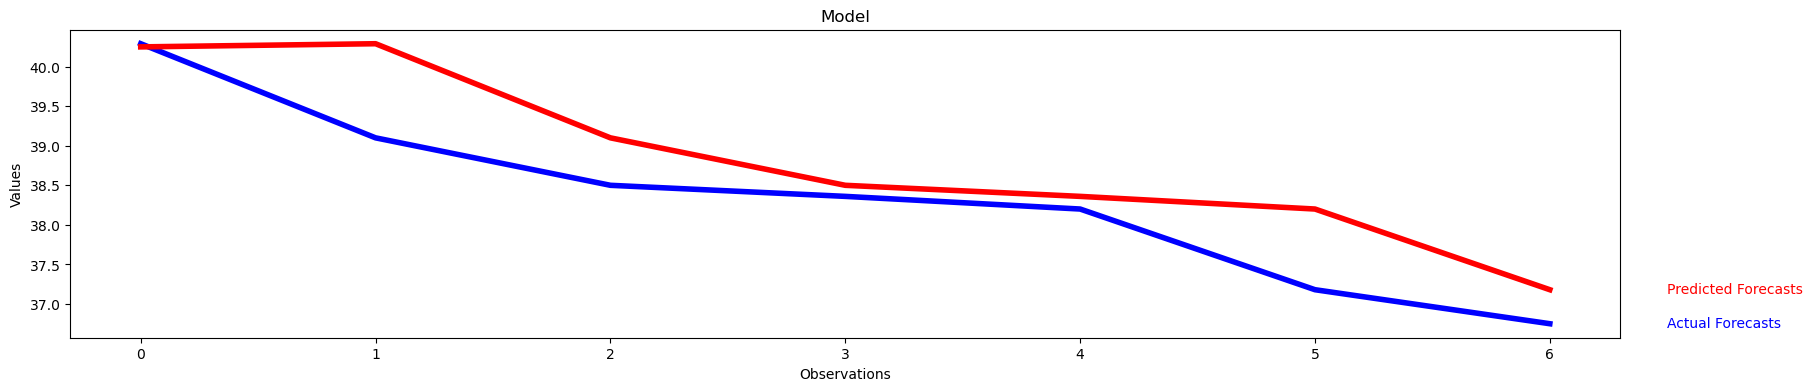

In [26]:
lags_to_test = []
EvaluationMetric.plot_forecast(expected_forecasts, rw_predictions, lags_to_test, with_lags=False)

### Initialize ARIMA Model for Raw Data

In [27]:
positive_pacor = [1, 2, 30]
negative_pacor = [5, 13, 19]
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)

integrated = 2

test_error_terms = [1, 2, 5, 13, 19, 30]

In [28]:
# create an object from the ARIMA_model() class
arima_model_class = ARIMA_model()

# call the function to train our ARIMA model
trained_arima_models = arima_model_class.train_arima_model(train_data_series, lags_to_test, test_error_terms, integrated)

ARIMA( 1 2 1 )


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3466
Model:             ARIMA(1, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4680.366
Date:                                Tue, 07 Nov 2023   AIC                           9376.731
Time:                                        16:00:43   BIC                           9425.933
Sample:                                             0   HQIC                          9394.300
                                               - 3466                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4321      0.111      3.904      0.000       0.215       0.649
ma.

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3466
Model:             ARIMA(2, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4678.525
Date:                                Tue, 07 Nov 2023   AIC                           9375.050
Time:                                        16:01:02   BIC                           9430.402
Sample:                                             0   HQIC                          9394.815
                                               - 3466                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4736      0.130      3.649      0.000       0.219       0.728
ar.

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 3466
Model:             ARIMA(5, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4677.392
Date:                                Tue, 07 Nov 2023   AIC                           9378.784
Time:                                        16:01:31   BIC                           9452.586
Sample:                                             0   HQIC                          9405.137
                                               - 3466                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3132      0.035     -8.964      0.000      -0.382      -0.245
ar.

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 3466
Model:             ARIMA(13, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4653.539
Date:                                 Tue, 07 Nov 2023   AIC                           9347.077
Time:                                         16:02:12   BIC                           9470.081
Sample:                                              0   HQIC                          9390.999
                                                - 3466                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4992      0.065     -7.677      0.000      -0.627      -0

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 3466
Model:             ARIMA(19, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4631.203
Date:                                 Tue, 07 Nov 2023   AIC                           9314.406
Time:                                         16:03:10   BIC                           9474.310
Sample:                                              0   HQIC                          9371.504
                                                - 3466                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6381      0.052    -12.200      0.000      -0.741      -0

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 3466
Model:             ARIMA(30, 2, [1, 2, 5, 13, 19, 30])   Log Likelihood               -4619.347
Date:                                 Tue, 07 Nov 2023   AIC                           9312.695
Time:                                         16:04:40   BIC                           9540.251
Sample:                                              0   HQIC                          9393.950
                                                - 3466                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4954      0.054     -9.195      0.000      -0.601      -0

In [29]:
len_historical_data, historical_data = train_raw.get_historical_data()
len_historical_data

3466

In [30]:
arima_predictions = arima_model_class.predict(trained_arima_models, len_historical_data, train_data_series, expected_forecasts)
arima_predictions

ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8f56be0> )
ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8f8b4f0> )
ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8f66d00> )
ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8f86070> )
ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8fa2df0> )
ARIMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8fa2ee0> )


[array([40.11584137, 40.02132957, 39.96926922, 39.95374637, 39.99247362,
        40.03373234, 40.06628486]),
 array([40.09483892, 39.96225862, 39.90346711, 39.89004168, 39.92298067,
        39.95599638, 39.97543317]),
 array([40.17778691, 40.07385396, 40.04534106, 40.0470154 , 40.01958423,
        39.98934168, 39.90649925]),
 array([40.21089605, 40.1710022 , 40.10759716, 40.13689842, 40.05639265,
        40.02001451, 39.88566235]),
 array([40.17819689, 40.01320042, 39.88172287, 39.88609689, 39.83382751,
        40.00517557, 40.0547399 ]),
 array([40.0920297 , 39.91035577, 39.8121892 , 39.80659063, 39.86033627,
        40.16140509, 40.25618827])]

In [31]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecasts, arima_predictions)
mse_gsts

expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.11584137 40.02132957 39.96926922 39.95374637 39.99247362 40.03373234
 40.06628486] mse 3.990350126450714
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.09483892 39.96225862 39.90346711 39.89004168 39.92298067 39.95599638
 39.97543317] mse 3.738651350665528
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.17778691 40.07385396 40.04534106 40.0470154  40.01958423 39.98934168
 39.90649925] mse 3.9088364104975035
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.21089605 40.1710022  40.10759716 40.13689842 40.05639265 40.02001451
 39.88566235] mse 4.034184412361138
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.17819689 40.01320042 39.88172

In [33]:
mse_gsts = EvaluationMetric.eval_rmse(expected_forecasts, arima_predictions)
mse_gsts

expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.11584137 40.02132957 39.96926922 39.95374637 39.99247362 40.03373234
 40.06628486] rmse 1.997586074854026
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.09483892 39.96225862 39.90346711 39.89004168 39.92298067 39.95599638
 39.97543317] rmse 1.9335592441571394
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.17778691 40.07385396 40.04534106 40.0470154  40.01958423 39.98934168
 39.90649925] rmse 1.977077745182901
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.21089605 40.1710022  40.10759716 40.13689842 40.05639265 40.02001451
 39.88566235] rmse 2.0085279217280347
expected [40.29000092 39.09999847 38.5        38.36000061 38.20000076 37.18000031
 36.75      ] predicted [40.17819689 40.01320042 39.

### Plot Actual Forecasts vs Predicted Forecasts for Raw Data

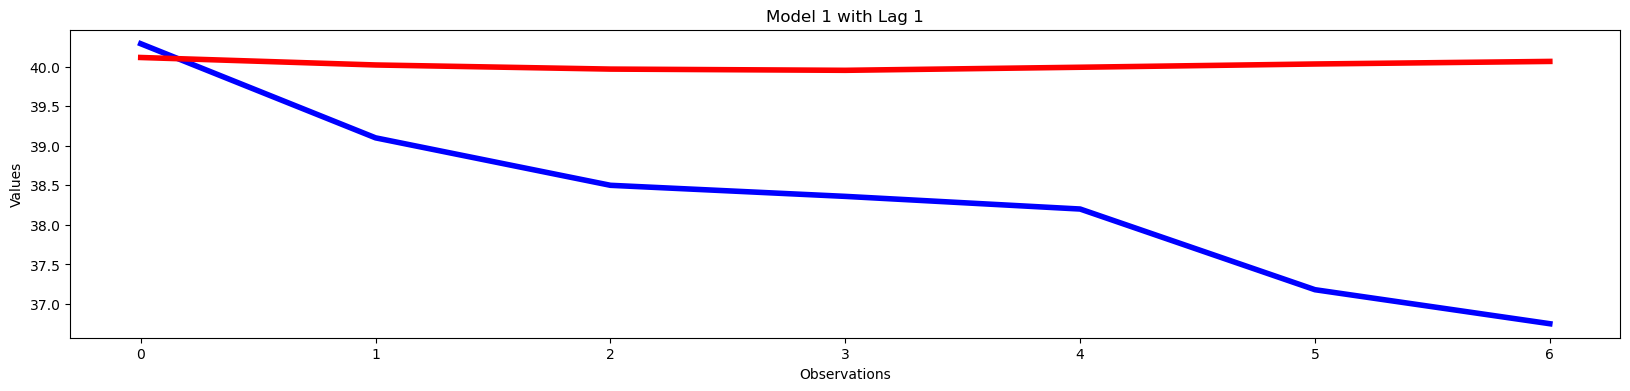

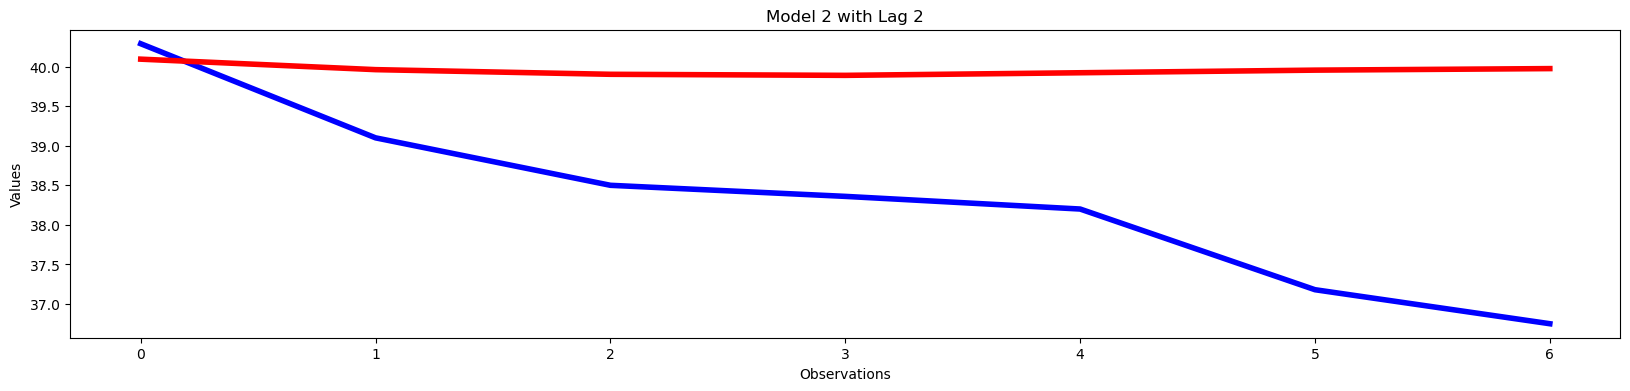

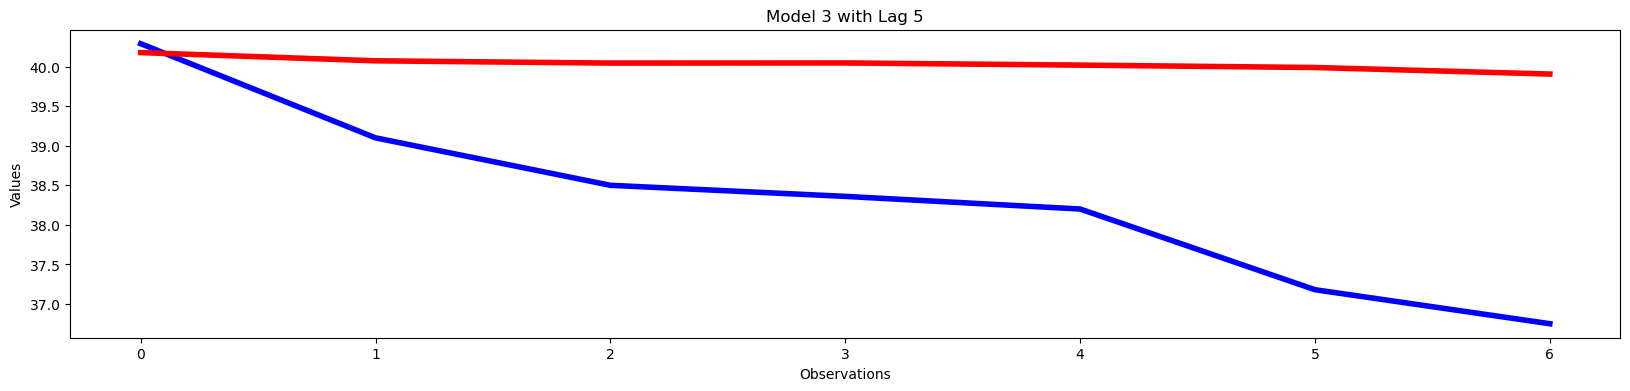

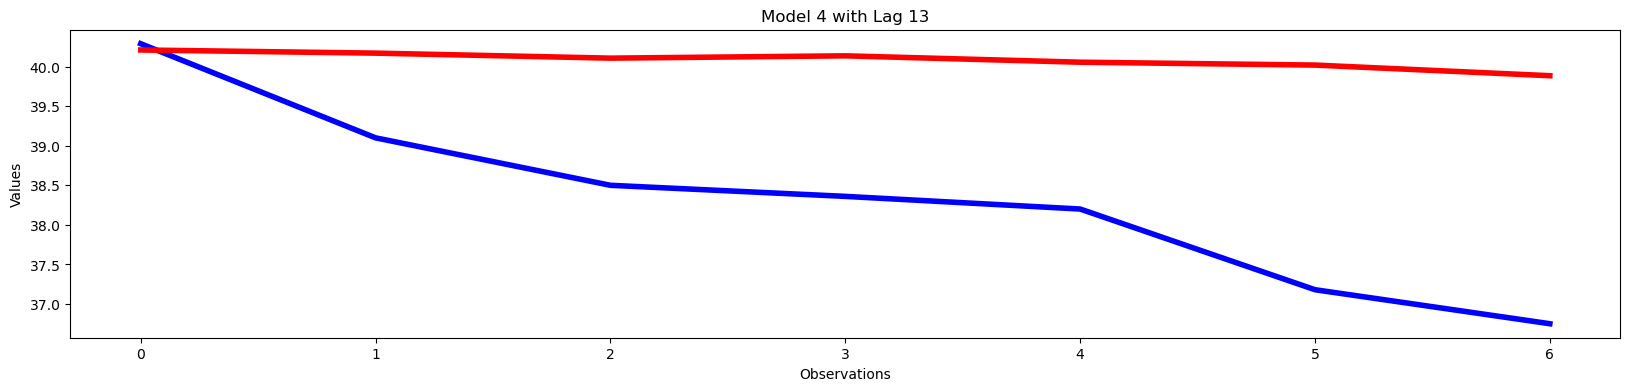

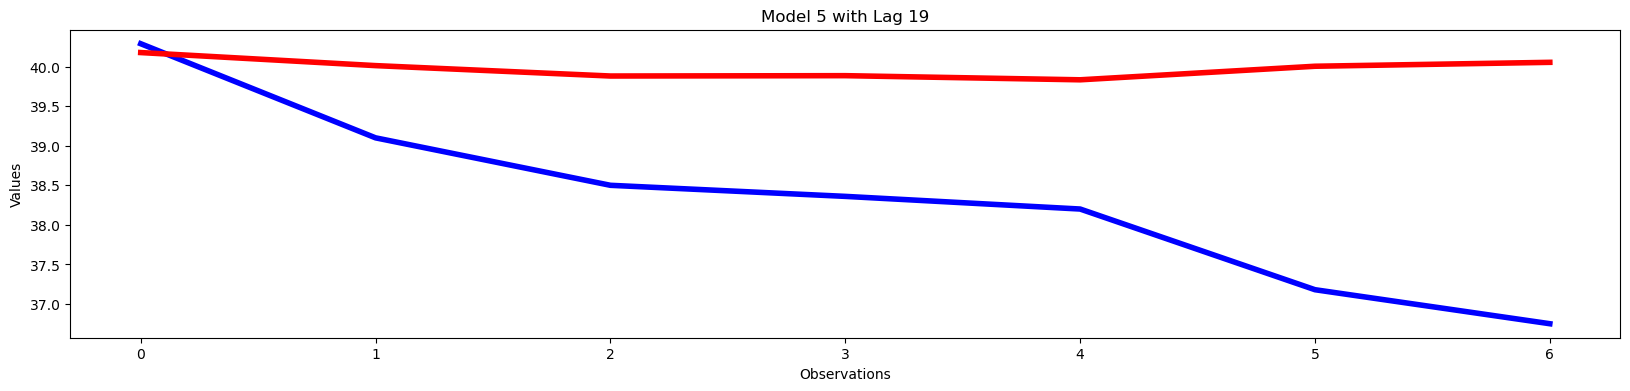

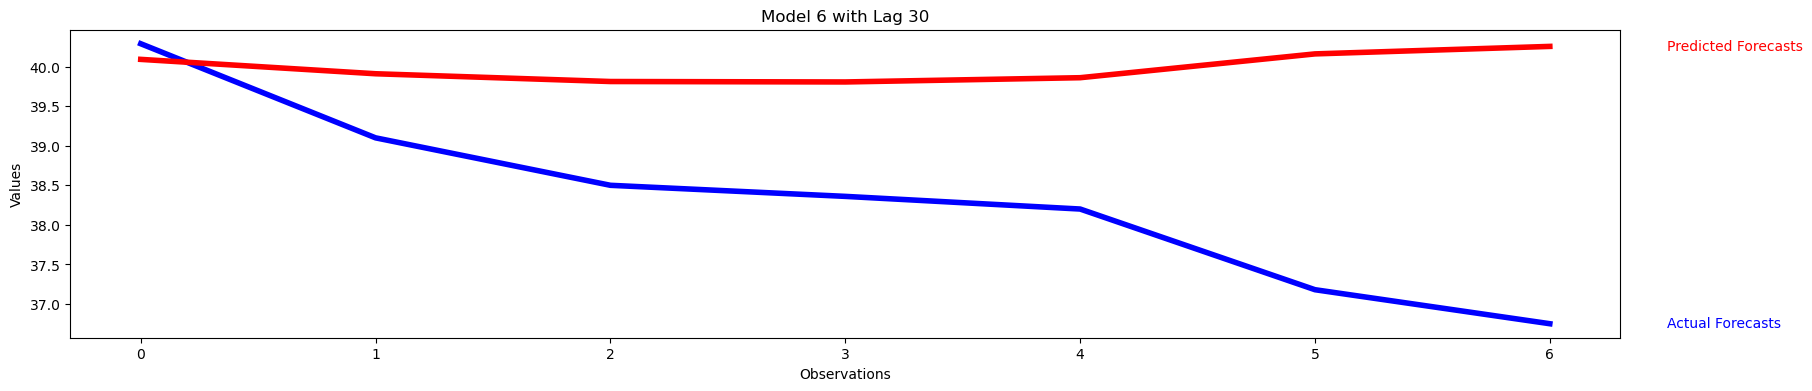

In [32]:
EvaluationMetric.plot_forecast(expected_forecasts, arima_predictions, lags_to_test, with_lags=True)

### Follow-up
- What can we determine from this?
    - `MSE` for the `RW` model is **0.435**. This performs better than all the `ARIMA` models as the best `MSE` is **3.73** for ARIMA(2, 2, 2).
    - `RMSE` for the `RW` model is **0.660**. This performs better than all the `ARIMA` models as the best `RMSE` is **1.93** for ARIMA(2, 2, 2).
    
- Can we do better?
    - We must lol!

- What to consider?
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis